Done by Sini Rahuman

In [ ]:
# ============================================================
# STEP 1 — Mount Google Drive
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================
# STEP 2 — Set Paths + Create Output Folders (Drive)
# ============================================================

import os

# ✅ Your CLEAN dataset split folder (already duplicate removed)
SPLIT_ROOT = "/content/drive/MyDrive/LungCancer_Project/split_70_15_15"
TRAIN_DIR = os.path.join(SPLIT_ROOT, "train")
VALID_DIR = os.path.join(SPLIT_ROOT, "valid")
TEST_DIR  = os.path.join(SPLIT_ROOT, "test")

print("SPLIT_ROOT exists:", os.path.exists(SPLIT_ROOT))
print("Train exists:", os.path.exists(TRAIN_DIR))
print("Valid exists:", os.path.exists(VALID_DIR))
print("Test exists :", os.path.exists(TEST_DIR))
print("Split contents:", os.listdir(SPLIT_ROOT))

# ✅ Hybrid outputs saved permanently in Drive
HYBRID_BASE = "/content/drive/MyDrive/Hybrid_CNN_Transformer"
MODEL_DIR = os.path.join(HYBRID_BASE, "models")
FIG_DIR   = os.path.join(HYBRID_BASE, "figures")
XAI_DIR   = os.path.join(HYBRID_BASE, "xai")
LOG_DIR   = os.path.join(HYBRID_BASE, "logs")

for d in [HYBRID_BASE, MODEL_DIR, FIG_DIR, XAI_DIR, LOG_DIR]:
    os.makedirs(d, exist_ok=True)

print("✅ Outputs will save to:", HYBRID_BASE)


SPLIT_ROOT exists: True
Train exists: True
Valid exists: True
Test exists : True
Split contents: ['train', 'valid', 'test']
✅ Outputs will save to: /content/drive/MyDrive/Hybrid_CNN_Transformer


In [ ]:
# ============================================================
# STEP 3 — Install Required Libraries
# ============================================================

!pip install -q shap scikit-learn


In [ ]:
# ============================================================
# STEP 4 — Confirm GPU
# ============================================================

import tensorflow as tf
print("GPU devices:", tf.config.list_physical_devices("GPU"))


GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# ============================================================
# STEP 5 — Speed Optimization (Mixed Precision)
# ============================================================

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")
print("✅ Mixed precision policy:", mixed_precision.global_policy())


✅ Mixed precision policy: <DTypePolicy "mixed_float16">


In [ ]:
# ============================================================
# STEP 6 — Import Libraries
# ============================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import os, json, glob
import cv2


In [ ]:
# ============================================================
# STEP 7 — Training Configuration
# ============================================================

IMG_SIZE = 160
BATCH_SIZE = 16            # smaller = faster + stable
NUM_CLASSES = 3
EPOCHS = 8
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
# ============================================================
# STEP 8 — Load CLEAN Dataset from Drive
# ============================================================

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VALID_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False
)

class_names = train_ds.class_names
print("✅ Classes:", class_names)

with open(os.path.join(LOG_DIR, "class_names.json"), "w") as f:
    json.dump(class_names, f, indent=2)


Found 9934 files belonging to 3 classes.
Found 2130 files belonging to 3 classes.
Found 2131 files belonging to 3 classes.
✅ Classes: ['lung_aca', 'lung_n', 'lung_scc']


In [ ]:
# ============================================================
# STEP 9 — Preprocess + Cache + Prefetch (Speed)
# ============================================================

preprocess = tf.keras.applications.efficientnet.preprocess_input

def prep(ds):
    ds = ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.cache().prefetch(AUTOTUNE)
    return ds

train_ds = prep(train_ds)
valid_ds = prep(valid_ds)
test_ds  = prep(test_ds)


In [ ]:
# ============================================================
# STEP 10 — Transformer Encoder Block
# ============================================================

def transformer_encoder(x, num_heads=2, key_dim=16, mlp_dim=128, dropout=0.1):
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(x1, x1)
    x2 = layers.Add()([x, attn])

    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    mlp = layers.Dense(mlp_dim, activation="gelu")(x3)
    mlp = layers.Dropout(dropout)(mlp)
    mlp = layers.Dense(x.shape[-1])(mlp)
    return layers.Add()([x2, mlp])


In [ ]:
# ============================================================
# STEP 11 — Build Hybrid CNN–Transformer Model
# ============================================================

def build_hybrid():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="image")

    backbone = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs
    )
    backbone.trainable = False

    feat = backbone.output
    tokens = layers.Reshape((-1, feat.shape[-1]))(feat)

    # ✅ Only 1 transformer block (fast, still “hybrid”)
    x = transformer_encoder(tokens, num_heads=2, key_dim=16, mlp_dim=128, dropout=0.1)

    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    # IMPORTANT: dtype float32 for final softmax with mixed precision
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

    model = keras.Model(inputs, outputs, name="Hybrid_EffNetB0_Transformer")
    return model

hybrid_model = build_hybrid()
hybrid_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "Hybrid_EffNetB0_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 160, 160,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 160, 160,  │          0 │ image[0][0]       │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 160, 160,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 160, 160,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 161, 161,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 80, 80,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 80, 80,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 80, 80,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 80, 80,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 80, 80,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 80, 80,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 80, 80,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 80, 80,    │        512 │ block1a_se_excit

 Total params: 4,555,398 (17.38 MB)

 Trainable params: 505,827 (1.93 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# ============================================================
# STEP 12 — Compile Model
# ============================================================

hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# ============================================================
# STEP 13 — Callbacks (Save best model to Drive)
# ============================================================

BEST_MODEL_PATH = os.path.join(MODEL_DIR, "best_hybrid.keras")

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
    tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor="val_accuracy", save_best_only=True)
]

print("✅ Best model will save to:", BEST_MODEL_PATH)


✅ Best model will save to: /content/drive/MyDrive/Hybrid_CNN_Transformer/models/best_hybrid.keras


In [ ]:
# ============================================================
# STEP 14 — Train Stage 1 (Frozen Backbone)
# ============================================================

history1 = hybrid_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

with open(os.path.join(LOG_DIR, "history_stage1.json"), "w") as f:
    json.dump(history1.history, f, indent=2)

print("✅ Saved history to Drive")
print("✅ Best model exists?", os.path.exists(BEST_MODEL_PATH))


Epoch 1/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 2366s 4s/step - accuracy: 0.8878 - loss: 0.3550 - val_accuracy: 0.9620 - val_loss: 0.1106 - learning_rate: 0.0010
Epoch 2/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9605 - loss: 0.1253 - val_accuracy: 0.9657 - val_loss: 0.0975 - learning_rate: 0.0010
Epoch 3/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9647 - loss: 0.1036 - val_accuracy: 0.9864 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 4/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9733 - loss: 0.0843 - val_accuracy: 0.9770 - val_loss: 0.0568 - learning_rate: 0.0010
Epoch 5/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9757 - loss: 0.0698 - val_accuracy: 0.9746 - val_loss: 0.0859 - learning_rate: 0.0010
Epoch 6/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9834 - loss: 0.0460 - val_accuracy: 0.9920 - val_loss: 0.0225 - learning_rate: 5.0000e-04
Epoch 7/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9926 - loss: 0.02

In [ ]:
# ============================================================
# STEP 15 — Evaluate Best Model on Test Set
# ============================================================

best_model = tf.keras.models.load_model(BEST_MODEL_PATH)

test_loss, test_acc = best_model.evaluate(test_ds, verbose=1)
print("✅ Test Accuracy:", test_acc)

with open(os.path.join(LOG_DIR, "test_results.txt"), "w") as f:
    f.write(f"test_loss: {test_loss}\n")
    f.write(f"test_accuracy: {test_acc}\n")


134/134 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.9874 - loss: 0.0255
✅ Test Accuracy: 0.9896762371063232


In [ ]:
history = hybrid_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCHS
)

Epoch 1/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9941 - loss: 0.0189 - val_accuracy: 0.9948 - val_loss: 0.0146
Epoch 2/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9951 - loss: 0.0143 - val_accuracy: 0.9930 - val_loss: 0.0174
Epoch 3/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9952 - loss: 0.0127 - val_accuracy: 0.9934 - val_loss: 0.0173
Epoch 4/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9953 - loss: 0.0138 - val_accuracy: 0.9934 - val_loss: 0.0135
Epoch 5/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9951 - loss: 0.0160 - val_accuracy: 0.9962 - val_loss: 0.0089
Epoch 6/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9962 - loss: 0.0094 - val_accuracy: 0.9939 - val_loss: 0.0166
Epoch 7/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9951 - loss: 0.0128 - val_accuracy: 0.9930 - val_loss: 0.0197
Epoch 8/8
621/621 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9972 - loss: 0.0073 - val_accuracy: 0.

In [ ]:
import os, glob
print(LOG_DIR)
print(glob.glob(os.path.join(LOG_DIR, "*")))

/content/drive/MyDrive/Hybrid_CNN_Transformer/logs
['/content/drive/MyDrive/Hybrid_CNN_Transformer/logs/class_names.json', '/content/drive/MyDrive/Hybrid_CNN_Transformer/logs/history_stage1.json', '/content/drive/MyDrive/Hybrid_CNN_Transformer/logs/test_results.txt', '/content/drive/MyDrive/Hybrid_CNN_Transformer/logs/y_true.npy', '/content/drive/MyDrive/Hybrid_CNN_Transformer/logs/y_pred.npy', '/content/drive/MyDrive/Hybrid_CNN_Transformer/logs/y_prob.npy', '/content/drive/MyDrive/Hybrid_CNN_Transformer/logs/classification_report.txt']


✅ Keys in saved history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


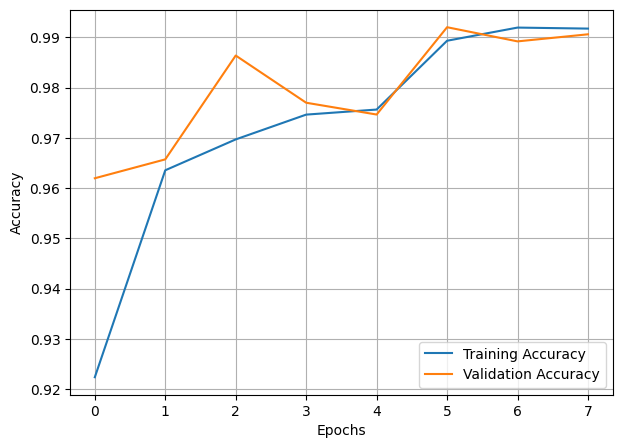

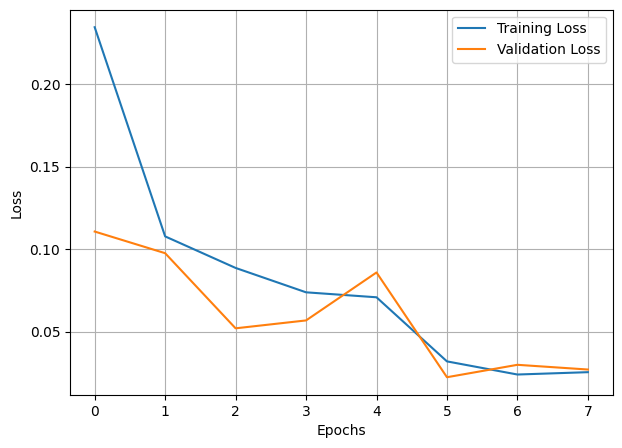

In [ ]:
import json
import matplotlib.pyplot as plt
import os

LOG_DIR = "/content/drive/MyDrive/Hybrid_CNN_Transformer/logs"
history_path = os.path.join(LOG_DIR, "history_stage1.json")

# Load history dict
with open(history_path, "r") as f:
    hist = json.load(f)

print("✅ Keys in saved history:", hist.keys())

# --- Accuracy plot ---
plt.figure(figsize=(7,5))
plt.plot(hist["accuracy"], label="Training Accuracy")
plt.plot(hist["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Loss plot ---
plt.figure(figsize=(7,5))
plt.plot(hist["loss"], label="Training Loss")
plt.plot(hist["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

History keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


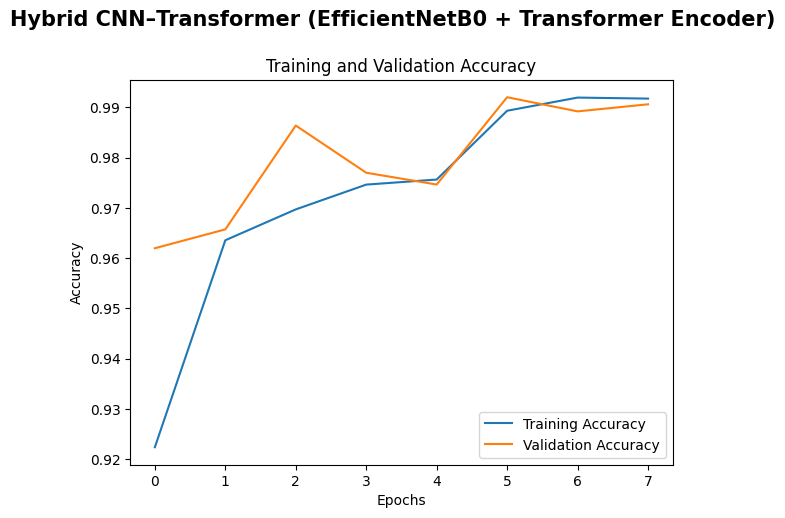

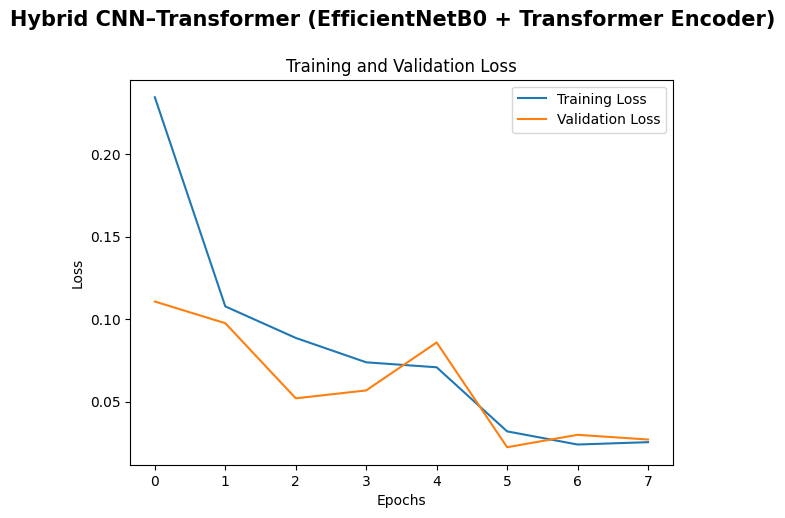

In [ ]:
import json
import matplotlib.pyplot as plt
import os

# Path to saved history
LOG_DIR = "/content/drive/MyDrive/Hybrid_CNN_Transformer/logs"
history_path = os.path.join(LOG_DIR, "history_stage1.json")

# Load history
with open(history_path, "r") as f:
    hist = json.load(f)

# Model name (EDIT if needed)
MODEL_NAME = "Hybrid CNN–Transformer (EfficientNetB0 + Transformer Encoder)"

print("History keys:", hist.keys())

# ===== Accuracy Plot =====
plt.figure(figsize=(7,5))
plt.suptitle(MODEL_NAME, fontsize=15, fontweight="bold", y=1.02)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(hist["accuracy"], label="Training Accuracy")
plt.plot(hist["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# ===== Loss Plot =====
plt.figure(figsize=(7,5))
plt.suptitle(MODEL_NAME, fontsize=15, fontweight="bold", y=1.02)
plt.title("Training and Validation Loss", fontsize=12)
plt.plot(hist["loss"], label="Training Loss")
plt.plot(hist["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# ============================================================
# STEP 16 — Save y_true, y_pred, y_prob (Drive)
# ============================================================

import numpy as np

y_true, y_pred = [], []
y_prob_list = []

for xb, yb in test_ds:
    probs = best_model.predict(xb, verbose=0)
    y_prob_list.append(probs)
    y_true.extend(np.argmax(yb.numpy(), axis=1))
    y_pred.extend(np.argmax(probs, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.vstack(y_prob_list)

np.save(os.path.join(LOG_DIR, "y_true.npy"), y_true)
np.save(os.path.join(LOG_DIR, "y_pred.npy"), y_pred)
np.save(os.path.join(LOG_DIR, "y_prob.npy"), y_prob)

print("✅ Saved y_true/y_pred/y_prob to:", LOG_DIR)


✅ Saved y_true/y_pred/y_prob to: /content/drive/MyDrive/Hybrid_CNN_Transformer/logs


              precision    recall  f1-score   support

    lung_aca     0.9818    0.9873    0.9846       710
      lung_n     0.9986    0.9902    0.9944       712
    lung_scc     0.9887    0.9915    0.9901       709

    accuracy                         0.9897      2131
   macro avg     0.9897    0.9897    0.9897      2131
weighted avg     0.9897    0.9897    0.9897      2131



<Figure size 640x480 with 0 Axes>

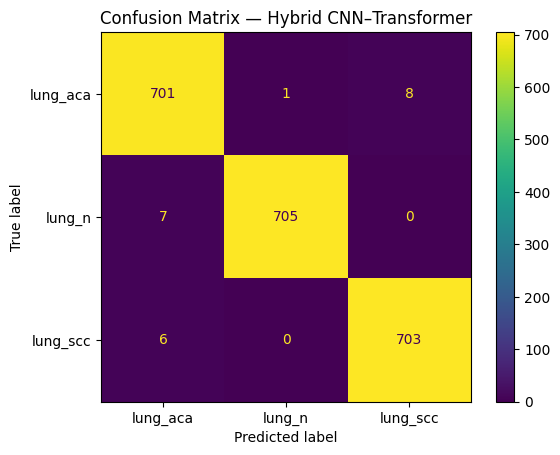

✅ Saved: /content/drive/MyDrive/Hybrid_CNN_Transformer/figures/confusion_matrix.png


In [ ]:
# ============================================================
# STEP 17 — Classification Report + Confusion Matrix (Save)
# ============================================================

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

with open(os.path.join(LOG_DIR, "classification_report.txt"), "w") as f:
    f.write(report)

cm = confusion_matrix(y_true, y_pred)

plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(values_format="d")
plt.title("Confusion Matrix — Hybrid CNN–Transformer")

cm_path = os.path.join(FIG_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved:", cm_path)


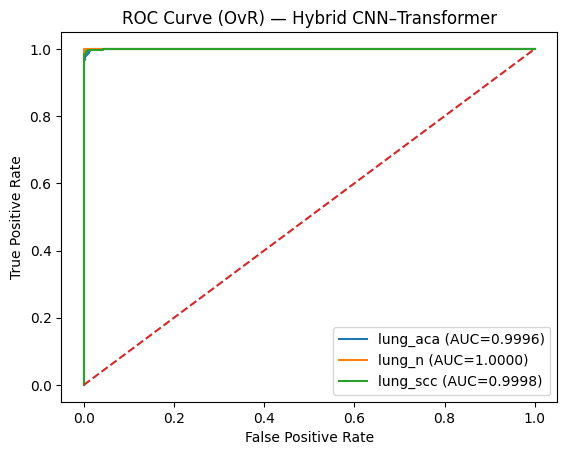

✅ Saved: /content/drive/MyDrive/Hybrid_CNN_Transformer/figures/roc_curve.png


In [ ]:
# ============================================================
# STEP 18 — ROC Curve (OvR) Save
# ============================================================

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))

plt.figure()
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OvR) — Hybrid CNN–Transformer")
plt.legend()

roc_path = os.path.join(FIG_DIR, "roc_curve.png")
plt.savefig(roc_path, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved:", roc_path)


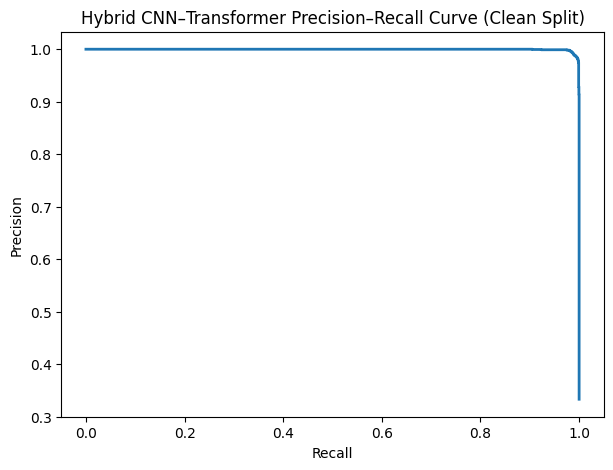

Average Precision (micro-avg): 0.9997


In [ ]:
#Precision–Recall Curve (ONE-TIME RUN CODE)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import os

# Paths
LOG_DIR = "/content/drive/MyDrive/Hybrid_CNN_Transformer/logs"

y_true = np.load(os.path.join(LOG_DIR, "y_true.npy"))
y_prob = np.load(os.path.join(LOG_DIR, "y_prob.npy"))

# Number of classes
num_classes = y_prob.shape[1]

# Binarize labels for multiclass PR
y_true_bin = label_binarize(y_true, classes=range(num_classes))

# Micro-average Precision-Recall
precision, recall, _ = precision_recall_curve(
    y_true_bin.ravel(), y_prob.ravel()
)
ap_score = average_precision_score(
    y_true_bin, y_prob, average="micro"
)

# ---- Precision–Recall Plot ----
plt.figure(figsize=(7,5))
plt.plot(recall, precision, linewidth=2)
plt.title("Hybrid CNN–Transformer Precision–Recall Curve (Clean Split)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print(f"Average Precision (micro-avg): {ap_score:.4f}")

In [ ]:
# ============================================================
# STEP 19 — Grad-CAM Save 10 Images per Class
# ============================================================

TARGET_LAYER = "top_conv"

grad_model = tf.keras.models.Model(
    inputs=best_model.inputs,
    outputs=[best_model.get_layer(TARGET_LAYER).output, best_model.output]
)

def make_gradcam_heatmap(img_array):
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def save_overlay(img_path, out_path, alpha=0.4):
    img_bgr = cv2.imread(img_path)
    img_bgr = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    arr = np.expand_dims(img_rgb.astype(np.float32), axis=0)
    arr = preprocess(arr)

    heatmap = make_gradcam_heatmap(arr)
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap_u8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_u8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = (img_rgb * (1 - alpha) + heatmap_color * alpha).astype(np.uint8)
    cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

for cls in class_names:
    cls_imgs = sorted(glob.glob(os.path.join(TEST_DIR, cls, "*.jpg")))[:10]
    for i, p in enumerate(cls_imgs, 1):
        out = os.path.join(XAI_DIR, f"{cls}_gradcam_{i}.png")
        save_overlay(p, out)

print("✅ Saved Grad-CAM images to:", XAI_DIR)


✅ Saved Grad-CAM images to: /content/drive/MyDrive/Hybrid_CNN_Transformer/xai


In [ ]:
# ============================================================
# DISPLAY A — Show saved Grad-CAM images from Drive
# ============================================================

import os, glob
import matplotlib.pyplot as plt
import cv2

XAI_DIR = "/content/drive/MyDrive/Hybrid_CNN_Transformer/xai"

imgs = sorted(glob.glob(os.path.join(XAI_DIR, "*.png")))[:12]  # show first 12
print("Found Grad-CAM images:", len(glob.glob(os.path.join(XAI_DIR, '*.png'))))

plt.figure(figsize=(14, 8))
for i, p in enumerate(imgs, 1):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.title(os.path.basename(p), fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()


Found Grad-CAM images: 0


<Figure size 1400x800 with 0 Axes>

In [ ]:
# ============================================================
# STEP 1 — Detect actual image extensions in test folder
# ============================================================

import os, glob

test_root = "/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test"

all_files = glob.glob(os.path.join(test_root, "*", "*"))
exts = sorted(set([os.path.splitext(f)[1].lower() for f in all_files]))

print("Total files:", len(all_files))
print("Detected extensions:", exts)

# Show some sample filenames
print("Sample files:", all_files[:10])


Total files: 2131
Detected extensions: ['.jpeg']
Sample files: ['/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca3438.jpeg', '/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca35.jpeg', '/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca4310.jpeg', '/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca2953.jpeg', '/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca2631.jpeg', '/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca4000.jpeg', '/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca4360.jpeg', '/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca4315.jpeg', '/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca2475.jpeg', '/content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca2840.jpeg']


Using image: /content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca1005.jpeg
Using TARGET_LAYER: top_conv


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['image']
Received: inputs=Tensor(shape=(1, 160, 160, 3))
  warnings.warn(msg)


Heatmap shape: (5, 5)
Heatmap min/max: 0.0 1.0
Predicted: lung_aca
Probabilities: [9.9942446e-01 2.1002440e-09 5.7557697e-04]


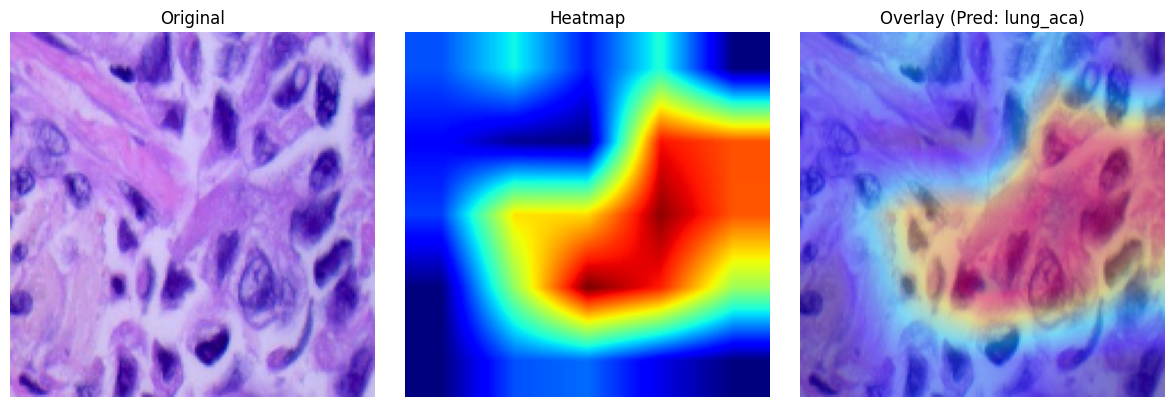

In [ ]:
# ============================================================
# FIXED DISPLAY — Robust Grad-CAM Visualization
# ============================================================

import os, glob, numpy as np, tensorflow as tf, cv2
import matplotlib.pyplot as plt

# ---------------- Pick image ----------------
chosen_class = "lung_aca"    # change if needed
cdir = os.path.join(TEST_DIR, chosen_class)
img_path = sorted(glob.glob(os.path.join(cdir, "*.jpeg")))[0]
print("Using image:", img_path)

# ---------------- Target layer ----------------
TARGET_LAYER = "top_conv"
print("Using TARGET_LAYER:", TARGET_LAYER)

grad_model = tf.keras.models.Model(
    inputs=best_model.inputs,
    outputs=[best_model.get_layer(TARGET_LAYER).output,
             best_model.output]
)

# ---------------- GradCAM function ----------------
def make_gradcam_heatmap(img_array):
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)

    # SAFETY: convert to numpy + clean
    conv_outputs = conv_outputs[0].numpy()
    grads = grads[0].numpy()

    # Global average pooling on gradients
    weights = np.mean(grads, axis=(0, 1))

    # Weighted sum
    heatmap = np.sum(weights * conv_outputs, axis=-1)

    # ReLU + normalize
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)

    return heatmap, preds.numpy()

# ---------------- Read image ----------------
img_bgr = cv2.imread(img_path)
img_bgr = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_array = np.expand_dims(img_rgb.astype(np.float32), axis=0)
img_array = preprocess(img_array)

# ---------------- Compute heatmap ----------------
heatmap, preds = make_gradcam_heatmap(img_array)

print("Heatmap shape:", heatmap.shape)
print("Heatmap min/max:", heatmap.min(), heatmap.max())

# ---------------- Resize safely ----------------
heatmap_resized = cv2.resize(
    heatmap.astype(np.float32),
    (IMG_SIZE, IMG_SIZE),
    interpolation=cv2.INTER_LINEAR
)

heatmap_u8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_u8, cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

# ---------------- Overlay ----------------
alpha = 0.4
overlay = (img_rgb * (1 - alpha) + heatmap_color * alpha).astype(np.uint8)

pred_class = class_names[int(np.argmax(preds[0]))]
print("Predicted:", pred_class)
print("Probabilities:", preds[0])

# ---------------- Display ----------------
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_rgb)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap_resized, cmap="jet")
plt.title("Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title(f"Overlay (Pred: {pred_class})")
plt.axis("off")

plt.tight_layout()
plt.show()


Using image: /content/drive/MyDrive/LungCancer_Project/split_70_15_15/test/lung_aca/lungaca1005.jpeg
Heatmap shape: (5, 5)
Heatmap min/max: 0.0 1.0
Predicted: lung_aca
Probabilities: [9.9942446e-01 2.1002440e-09 5.7557697e-04]


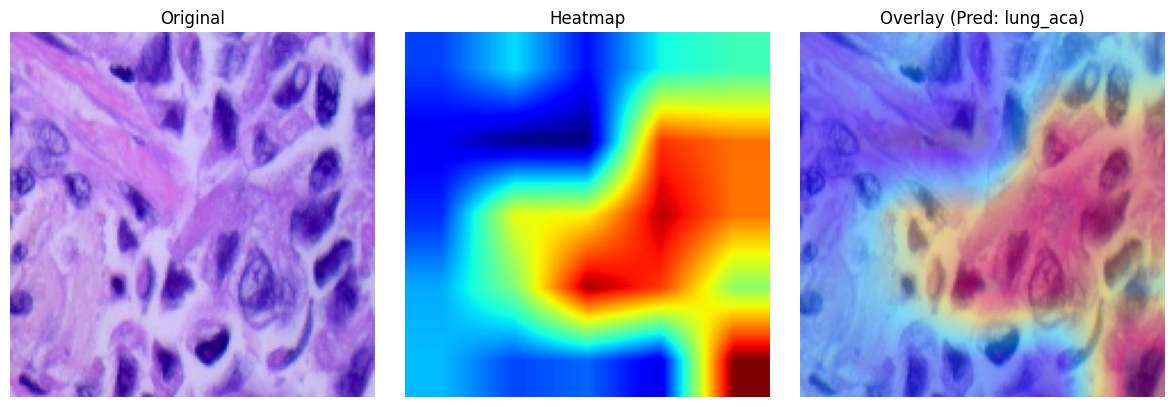

In [ ]:
# ============================================================
# IMPROVED Grad-CAM — log(prob) target + safe normalization
# ============================================================

import os, glob, numpy as np, tensorflow as tf, cv2
import matplotlib.pyplot as plt

chosen_class = "lung_aca"
img_path = sorted(glob.glob(os.path.join(TEST_DIR, chosen_class, "*.jpeg")))[0]
print("Using image:", img_path)

TARGET_LAYER = "top_conv"

grad_model = tf.keras.models.Model(
    inputs=best_model.inputs,
    outputs=[best_model.get_layer(TARGET_LAYER).output, best_model.output]
)

def make_gradcam_heatmap_logprob(img_array, eps=1e-8):
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)
        class_idx = tf.argmax(preds[0])
        # Use log(prob) to avoid gradient collapse at extreme probs
        score = tf.math.log(preds[:, class_idx] + eps)

    grads = tape.gradient(score, conv_outputs)

    conv_outputs = conv_outputs[0].numpy()
    grads = grads[0].numpy()

    weights = np.mean(grads, axis=(0, 1))
    heatmap = np.sum(weights * conv_outputs, axis=-1)

    # Use absolute value before ReLU to avoid all-zero case
    heatmap = np.abs(heatmap)

    # Normalize safely
    heatmap -= heatmap.min()
    denom = heatmap.max() + eps
    heatmap = heatmap / denom

    return heatmap, preds.numpy()

# Read image
img_bgr = cv2.imread(img_path)
img_bgr = cv2.resize(img_bgr, (IMG_SIZE, IMG_SIZE))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

img_array = np.expand_dims(img_rgb.astype(np.float32), axis=0)
img_array = preprocess(img_array)

heatmap, preds = make_gradcam_heatmap_logprob(img_array)

print("Heatmap shape:", heatmap.shape)
print("Heatmap min/max:", heatmap.min(), heatmap.max())

# Resize + overlay
heatmap_resized = cv2.resize(heatmap.astype(np.float32), (IMG_SIZE, IMG_SIZE))
heatmap_u8 = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_u8, cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

alpha = 0.4
overlay = (img_rgb * (1 - alpha) + heatmap_color * alpha).astype(np.uint8)

pred_class = class_names[int(np.argmax(preds[0]))]
print("Predicted:", pred_class)
print("Probabilities:", preds[0])

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap_resized, cmap="jet"); plt.title("Heatmap"); plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay); plt.title(f"Overlay (Pred: {pred_class})"); plt.axis("off")

plt.tight_layout()
plt.show()
